### Load Libraries

In [6]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import scipy
import time

rng = np.random.RandomState(123)
tf.random.set_seed(42)

### Utility Functions

In [2]:

def resort_data(X_test, *args):
    """
    Function to resort data, such that they are in ascending order wrt X_test. Useful for plotting curves.

    Args:
        X_test (array)

    Returns:
        X_test reordered
    """


    X_test, *args = zip(*sorted(zip(X_test, *args)))

    X_test = np.array(X_test)
    
    args = [np.array(arg) for arg in args]

    return X_test, *args

In [3]:
## 
def load_1D_dataset(N_total=200, test_set_proportion=0.2):
    """
    Function to load a customisable toy 1D regression dataset

    Args:
        N_total (int, optional): Total number of data points. Defaults to 200.
        test_set_proportion (float, optional): Proportion of test point to all data points. Defaults to 0.2.
    """
    
    def func(x):
        return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

    N_tot = N_total  # Number of total input points (training and test)

    X = rng.rand(N_tot, 1) * 2 - 1  # X values
    Y = func(X) + 0.2 * rng.randn(N_tot, 1)  # Noisy Y values

    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X,
        Y,
        test_size=test_set_proportion,
        random_state=88,
        shuffle=True
        )

    X_test, Y_test = resort_data(X_test, Y_test)

    return  X_train, X_test, Y_train, Y_test




In [3]:

def load_dataset(dataset="1D", y_hot_encoding=True):
    """
    Dataset loading utility function.

    Args:
        dataset (str, optional): the string of the dataset to be loaded. Defaults to "1D".

    Returns:
        Training and test outputs. One hot encoding for classification datasets.
    """
    if dataset=="1D":
        x_train, x_test, y_train, y_test = load_1D_dataset()
        return x_train, x_test, y_train, y_test
    elif dataset=="mnist":
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        assert x_train.shape == (60000, 28, 28)
        assert x_test.shape == (10000, 28, 28)
        assert y_train.shape == (60000,)
        assert y_test.shape == (10000,)

        # preprocessing
        x_train = x_train.reshape(60000, 784)/255
        x_test = x_test.reshape(10000, 784)/255
        
    else:
        if dataset=="diabetes":
            data = load_diabetes()
        if dataset=="breast":
            data = load_breast_cancer()
        if dataset=="iris":
            data = load_iris()
        if dataset=="digits":
            data = load_digits()


        y = data["target"]
        #y = np.array([float(y_one) for y_one in y])
        X = data["data"]
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


        
        # print(C)


    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    N = len(y_train)

    if (dataset=="breast" or "iris" or "digits" or "mnist") and y_hot_encoding==True:

        C = len(unique_labels(y_train))
        y_hot = np.zeros((N, C))
        
        y_hot = OneHotEncoder(handle_unknown='ignore').fit_transform(y_train).toarray()

        # print("poo")

        #y_hot = y_hot.reshape(-1, 1)

        return x_train, x_test, y_hot, y_test

    else:

        D = len(x_train[0])

        return x_train, x_test, y_train, y_test




In [5]:
def LPD_fn(Y_predict_mu, Y_predict_var, Y_test):
    """
        Loss function - negative log validation density loss.

    Args:
        - X_train: Input values for training dataset
        - Y_train: Output values for training dataset
        - X_test: Input values for test dataset

    Returns:
        - Y_predict_mu: Predicted output values for inputs X_test
        - Y_predict_var: The variances for Y_predict_mu

    
    """

    term_1 = np.log(Y_predict_var)
    term_2 = ((Y_predict_mu - Y_test)**2)/(Y_predict_var)
    term_3 = np.log(2*np.pi)
    return np.sum(-0.5*(term_1+term_2+term_3))


# ! this function doesnt make sense yet
def MSE(Y_predict_mu, Y_predict_var, Y_test):
    return np.mean((Y_predict_mu - Y_test)**2)

In [4]:
class Stopwatch():

    def __init__(self):
        self.current_time = 0

    def start(self):
        self.start_time = time.time()
        
    def stop(self):
        self.current_time += time.time()-self.start_time

    def reset(self):
        self.current_time = 0 
        pass    

    def read_time(self):
        return self.current_time

### Experiments

##### SGPR

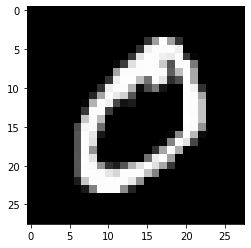

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [27]:
x_train, x_test, y_train, y_test = load_dataset(dataset="mnist")

plt.imshow(x_train[1].reshape(28, 28), cmap='gray')
plt.show()

print(type(y_train[1]))
print(type(x_train[1]))
print(type(x_train[1,1]))

Initialising the model

In [20]:

#* Number of inducing points
M = 100

#* Random initialisation of inducing points
Z_SGPR = x_train[:M, :].copy()

#* Number of classes for a classification dataset
C = len(unique_labels(y_train))


#* ARD SE kernel
kernel_ard = gpflow.kernels.SquaredExponential(lengthscales=np.ones(len(x_train[0])))
#* SE kernel
kernel = gpflow.kernels.SquaredExponential()


#* Initialise the model
m = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel,
    )
    

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, True)

#* Pick value for jitter
jitter = 1e-3
gpflow.config.set_default_jitter(jitter)


#* Initialise hyperparams
var_y = 1
var_f = var_y
kappa = 1
var_n = var_f / kappa

m.likelihood.variance.assign(var_n)
m.kernel.variance.assign(var_y)
m.kernel.lengthscales.assign(10)



m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(100, 784)",float64,"[[0., 0., 0...."


Training the model by optimising the ELBO

In [61]:
# #-- Optimisation

#* Optimiser object
opt = gpflow.optimizers.Scipy()
opt_adam = tf.optimizers.Adam(learning_rate=0.1)

#* List for ELBO values during 
logs = []
accuracies = []
times = []

watch = Stopwatch()
watch.reset()

def log_opt(x):
    """
    Utility function to log the elbo score for each iteration during optimisaiton.

    Args:
        x
    """
    watch.stop()
    logs.append(float(m.elbo()))
    times.append(watch.read_time())
    y_pred, var = m.predict_y(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
    accuracies.append(accuracy_score(y_test, y_pred_labels))
    watch.start()
    
    # logs.append(float(m.log_marginal_likelihood()))

def run_adam(iterations):
    for i in range(iterations):
        opt_adam.minimize(
            m.training_loss,
            m.trainable_variables,
            )
        log_opt(1)

watch.start()  # --Start the watch


#* Optimise
# log = opt.minimize(
#     m.training_loss,
#     m.trainable_variables,
#     options=dict(maxiter=300),
#     callback=log_opt,
#     )
run_adam(100)


watch.stop() # --Stop the watch for the final time
print("Total time for optimisation:", watch.read_time())



Total time for optimisation: 219.9868359565735


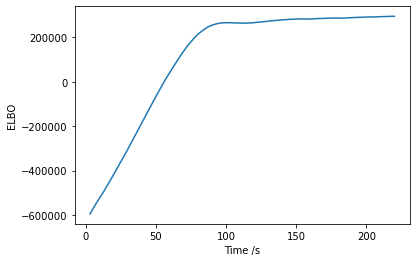

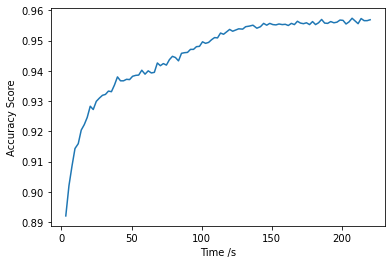

In [62]:
# print(logs)
plt.figure()
plt.plot(times, logs)
plt.xlabel("Time /s")
plt.ylabel("ELBO")
plt.show()

plt.figure()
plt.plot(times, accuracies)
plt.xlabel("Time /s")
plt.ylabel("Accuracy Score")
plt.show()

In [17]:
print(len(logs))

21


In [116]:
# #-- Show the new model parameters
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.009226140657825859
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.117649089461928
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.018631413001187595
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(1000, 784)",float64,"[[0., 0., 0...."


In [117]:
print(m.elbo())

tf.Tensor(302908.3678140197, shape=(), dtype=float64)


Making predictions

In [118]:
y_pred, var = m.predict_y(x_test)

print(y_pred[:4])

print(np.shape(x_test))
print(np.shape(y_test))
print(np.shape(y_pred))
print(np.shape(x_train))
print(np.shape(y_train))


tf.Tensor(
[[-0.02180869 -0.01871783 -0.00572968  0.00664324 -0.04052388  0.01313393
   0.00787949  1.06132869  0.05770783 -0.05171545]
 [ 0.06165025 -0.09523178  0.68783787  0.19215618 -0.04555698 -0.0218745
   0.21037257  0.0064164  -0.02666623  0.00434883]
 [ 0.00389339  0.96462501  0.00556539 -0.02839849  0.00391607  0.04538193
   0.01367806 -0.00814623 -0.00747944  0.01121672]
 [ 0.93504778  0.01380227 -0.04284333  0.05176945  0.01351825 -0.00891388
   0.05962564  0.0494236   0.00904066 -0.08610958]], shape=(4, 10), dtype=float64)
(10000, 784)
(10000, 1)
(10000, 10)
(60000, 784)
(60000, 10)


In [119]:
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
# print(MSE(y_pred, var, y_test))
# print(LPD_fn(y_pred, var, y_test))

# //plt.scatter(x_test, y_pred)
# //plt.scatter(x_train, y_train, color='black')
# //plt.show()

print(accuracy_score(y_test, y_pred_labels))

0.9525


In [120]:

print(y_pred_labels[:20].reshape(1,-1))
print(y_test[:20].reshape(1,-1))

[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]


##### SGPR - Tuning Hyperparams separately

In [196]:
#* Number of inducing points
M = 100

#* Random initialisation of inducing points
Z_SGPR = x_train[:M, :].copy()

#* Number of classes for a classification dataset
C = len(unique_labels(y_train))


#* ARD SE kernel
kernel_ard = gpflow.kernels.SquaredExponential(lengthscales=np.ones(len(x_train[0])))
#* SE kernel
kernel = gpflow.kernels.SquaredExponential()


#* Initialise the model
m = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel,
    )
    

#* Pick value for jitter
jitter = 1e-3
gpflow.config.set_default_jitter(jitter)


#* Initialise hyperparams
var_y = 1
var_f = var_y
kappa = 1
var_n = var_f / kappa

m.likelihood.variance.assign(var_n)
m.kernel.variance.assign(var_y)
m.kernel.lengthscales.assign(10)

m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(100, 784)",float64,"[[0., 0., 0...."


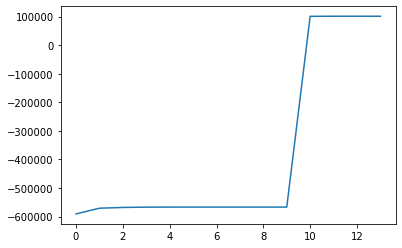

In [197]:
# #-- Optimisation

#* Optimiser object
opt = gpflow.optimizers.Scipy()

def log_opt(x):
    """
    Utility function to log the elbo score for each iteration during optimisaiton.

    Args:
        x
    """
    logs.append(float(m.elbo()))
    # logs.append(float(m.log_marginal_likelihood()))

#* List for ELBO values during 
logs = []

# #-- Optimising kernel variance first (optimising lengthscale first didn't work well)

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, False)
gpflow.set_trainable(m.likelihood.variance, False)
gpflow.set_trainable(m.kernel.lengthscales, False)
gpflow.set_trainable(m.kernel.variance, True)

#* Optimise
log = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=30),
    callback=log_opt,
    )



# #-- Optimisation 2

opt_iter_2 = len(logs)

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, False)
gpflow.set_trainable(m.likelihood.variance, False)
gpflow.set_trainable(m.kernel.lengthscales, True)
gpflow.set_trainable(m.kernel.variance, False)

#* Optimise
log = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=30),
    callback=log_opt,
    )


# #-- Optimisation 3

opt_iter_3 = len(logs)

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, False)
gpflow.set_trainable(m.likelihood.variance, True)
gpflow.set_trainable(m.kernel.lengthscales, False)
gpflow.set_trainable(m.kernel.variance, False)

#* Optimise
log = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=30),
    callback=log_opt,
    )

# print(logs)
plt.plot(logs)
#plt.vlines([opt_iter_2, opt_iter_3], np.min(logs), np.max(logs), alpha=0.3)
plt.show()



In [190]:
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,False,(),float64,0.0449782462986858
SGPR.kernel.lengthscales,Parameter,Softplus,,False,(),float64,9.462215892347995
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.025803899670010406
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(500, 784)",float64,"[[0., 0., 0...."


In [191]:
y_pred, var = m.predict_y(x_test)
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
print(accuracy_score(y_test, y_pred_labels))

0.9381


##### SGPR - Hyperparameter search

In [25]:

#* Initialise the model
m_search = gpflow.models.SGPR(
    data=(x_train, y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel,
    )

m_search

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.10000000000000002
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(50, 784)",float64,"[[0., 0., 0...."


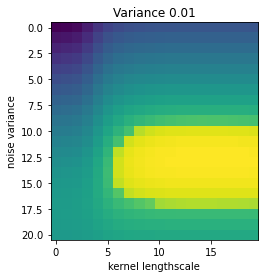

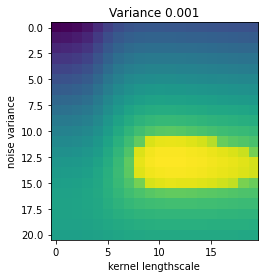

In [175]:

var_range = [1e-2, 1e-3];

noise_range = np.geomspace(0.005, 0.16, 21)

len_range = np.linspace(1, 10, 20)

elbos = []
for var_y in var_range:

    elbo_y = []
    m_search.kernel.variance.assign(var_y)
    
    for var_n in noise_range:
        m_search.likelihood.variance.assign(var_n)
        elbo_n = []
        for lengthscale in len_range:
            m_search.kernel.lengthscales.assign(lengthscale)
            elbo_l = m_search.elbo()
            elbo_n.append(elbo_l)
        elbo_y.append(elbo_n)
    elbos.append(elbo_y)
    plt.imshow(np.cbrt(elbo_y))
    plt.xlabel("kernel lengthscale")
    plt.title("Variance {}".format(var_y))
    plt.ylabel("noise variance")
    plt.show()

##### SVGP

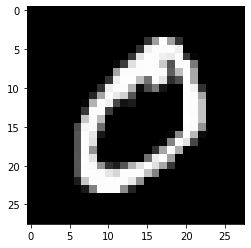

(60000, 1)
(60000, 784)
<class 'numpy.float64'>


In [ ]:
x_train, x_test, y_train, y_test = load_dataset(dataset="mnist", y_hot_encoding=False)

plt.imshow(x_train[1].reshape(28, 28), cmap='gray')
plt.show()

print(np.shape(y_train))
print(np.shape(x_train))
print(type(x_train[1,1]))

data=(x_train, y_train)



In [9]:

#* Number of inducing points
M = 100

#* Random initialisation of inducing points
Z_SVGP = x_train[:M, :].copy()

#* Number of classes for a classification dataset
C = len(unique_labels(y_train))

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(C, invlink=invlink)  # Multiclass likelihood
gaussian_like = gpflow.likelihoods.Gaussian() # Gaussian likelihood

kernel = gpflow.kernels.SquaredExponential()

#* Initialise the model
m_SVGP = gpflow.models.SVGP(
    #data=(x_train, y_train),
    inducing_variable=Z_SVGP,
    kernel=kernel,
    num_latent_gps=C,
    likelihood=gaussian_like,
    )


#* Set trainable parameters
gpflow.set_trainable(m_SVGP.inducing_variable, False)
gpflow.set_trainable(m_SVGP.kernel, False)
gpflow.set_trainable(m_SVGP.likelihood, False)

#* Initialise hyperparams
var_y = 1
var_f = var_y
kappa = 1
var_n = var_f / kappa

# m_SVGP.likelihood.variance.assign(var_n)
m_SVGP.kernel.variance.assign(var_y)
m_SVGP.kernel.lengthscales.assign(10)

print(np.shape(x_train))
print(np.shape(y_train))

m_SVGP

(60000, 784)
(60000, 1)


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,False,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,False,(),float64,10.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 784)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(100, 10)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(10, 100, 100)",float64,"[[[1., 0., 0...."


In [22]:
# #-- Optimisation



#* Optimiser object
opt = gpflow.optimizers.Scipy()

#* List for ELBO values during 
logs_SVGP = []

watch = Stopwatch()
watch.reset()

def log_opt_SVGP(x):
    """
    Utility function to log the elbo score for each iteration during optimisaiton.

    Args:
        x
    """
    logs_SVGP.append(float(m_SVGP.elbo(data)))
    # logs.append(float(m.log_marginal_likelihood()))



#* Optimise
log_SVGP = opt.minimize(
    m_SVGP.training_loss_closure(data),
    m_SVGP.trainable_variables,
    options=dict(maxiter=1000),
    callback=log_opt_SVGP,
    )

# print(logs)
plt.plot(logs_SVGP)
plt.show()

KeyboardInterrupt: 

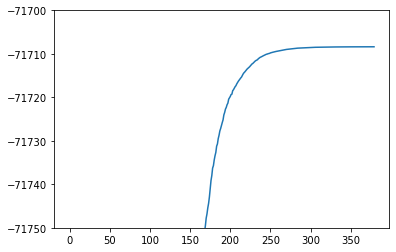

In [244]:
plt.plot(logs_SVGP)
plt.ylim(-71750,-71700)
plt.show()

In [26]:
print(m_SVGP.elbo(data))

y_pred, var = m_SVGP.predict_y(x_test)
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
print(accuracy_score(y_test, y_pred_labels))

print(y_pred_labels[:20].reshape(1, -1))
print(y_test[:20].reshape(1, -1))



tf.Tensor(-491664.8871761263, shape=(), dtype=float64)
0.098
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]]


#### Comparing Models

In [12]:
def train_mnist(
    model,
    num_ind_points,
    num_iterations,
    train_ind_points=True,
    learning_rate_adam=0.1,
    minibatch_size=None,
    ):
    """Trains sparse GP models on MNIST dataset.

    Args:
        model (str): model with which to train on MNIST dataset
        num_ind_points (int): Number of inducing points to be used in the model.
        num_iterations (int): Number of iterations during optimisation.
        train_ind_points (bool, optional): Set inducing points to be a trainable parameter. Defaults to True.
        learning_rate_adam (float, optional): Learning rate to use in Adam optimiser. Defaults to 0.01.
        minibatch_size (int, optional): Size of minibatch to use during optimisation. Defaults to None (full batch training).

    Returns:
        model (GPflow model object)
        times (array)
        elbo_logs (array)
        accuracy_logs (array)
    """

    if not model == "SGPR" and not model == "SVGP":
        raise ValueError("Model must be either SGPR or SVGP.")
    if not type(num_ind_points) is int:
        raise ValueError("Number of inducing points must be an integer.")
    if not type(train_ind_points) is bool:
        raise ValueError("train_ind_points must be boolean.")
    if not type(num_iterations) is int:
        raise ValueError("Iterations must be an integer.")
    if minibatch_size is not None and not type(minibatch_size) is int:
            raise ValueError("Minibatch size must be an integer.")

    y_hot_encoding = model=="SGPR"

    x_train, x_test, y_train, y_test = load_dataset(dataset="mnist", y_hot_encoding=y_hot_encoding)

    data=(x_train, y_train)

    N = len(y_train)

    #* Number of inducing points
    M = num_ind_points

    #* Random initialisation of inducing points
    Z = x_train[:M, :].copy()

    #* Number of classes for a classification dataset
    C = len(unique_labels(y_train))

    #* Robustmax Multiclass Likelihood
    invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
    likelihood = gpflow.likelihoods.MultiClass(C, invlink=invlink)  # Multiclass likelihood
    gaussian_like = gpflow.likelihoods.Gaussian()

    #* Kernel
    kernel = gpflow.kernels.SquaredExponential()

    #* Initialise the model
    if model=="SVGP":
        m = gpflow.models.SVGP(
            inducing_variable=Z,
            kernel=kernel,
            num_latent_gps=C,
            likelihood=likelihood,
            )
    if model=="SGPR":
        m = gpflow.models.SGPR(
            data=data,
            inducing_variable=Z,
            kernel=kernel,
            )

    #* Pick value for jitter
    jitter = 1e-3
    gpflow.config.set_default_jitter(jitter)

    #* Set trainable parameters
    gpflow.set_trainable(m.inducing_variable, train_ind_points)

    #* Initialise hyperparams
    var_y = 1
    var_f = var_y
    kappa = 1
    var_n = var_f / kappa

    # m_SVGP.likelihood.variance.assign(var_n)
    m.kernel.variance.assign(var_y)
    m.kernel.lengthscales.assign(10)

    #* Optimiser object
    opt = tf.optimizers.Adam(learning_rate=learning_rate_adam)

    #* List for ELBO values during 
    elbo_logs = []
    accuracy_logs = []
    times = []

    watch = Stopwatch()
    watch.reset()

    n_logs = 200

    def log_opt():
        """
        Utility function to log the elbo score for each iteration during optimisaiton.

        Args:
            x
        """
        watch.stop()
        if model == "SGPR":
            ELBO =  m.elbo()
        elif model=="SVGP":
            ELBO =  m.elbo(data)
        elbo_logs.append(float(ELBO))
        times.append(watch.read_time())
        y_pred, var = m.predict_y(x_test)
        y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
        accuracy_logs.append(accuracy_score(y_test, y_pred_labels))
        watch.start()
        
        # logs.append(float(m.log_marginal_likelihood()))


    if model=="SGPR":
        training_loss=m.training_loss

    if model=="SVGP" and minibatch_size is None:
        training_loss= m.training_loss_closure(data)
    if model=="SVGP" and minibatch_size is not None:
        train_dataset = tf.data.Dataset.from_tensor_slices((data)).repeat().shuffle(N)
        train_iter = iter(train_dataset.batch(minibatch_size))
        training_loss = m.training_loss_closure(train_iter, compile=True)

    def run_adam(iterations):
        for i in range(iterations):
            opt.minimize(
                training_loss,
                m.trainable_variables,
                )
            freq = iterations//n_logs 
            if i % freq == 0:  #-- only log every freq iterations
                log_opt()

    watch.start()  # --Start the watch


    #* Optimise
    run_adam(num_iterations)


    watch.stop() # --Stop the watch for the final time
    print("Model: {}".format(model))
    print("Number of inducing points: {}".format(num_ind_points))
    print("Total time for optimisation: {} seconds".format(watch.read_time()))
    gpflow.utilities.print_summary(m, fmt="notebook")

    return m, times, elbo_logs, accuracy_logs


In [94]:
m_SGPR_Z, times_Z, elbos_Z, accuracies_Z = train_mnist(model="SGPR", num_ind_points=500, train_ind_points=True, num_iterations=200 )
m_SGPR, times, elbos, accuracies = train_mnist(model="SGPR", num_ind_points=500, train_ind_points=False, num_iterations=200 )

Model: SGPR
Number of inducing points: 500
Total time for optimisation: 1524.0462017059326 seconds


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.007805522379905838
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.448216970962651
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.012400270533327137
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(500, 784)",float64,"[[0., 0., 0...."


Model: SGPR
Number of inducing points: 500
Total time for optimisation: 1555.1997833251953 seconds


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.007963949103896204
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.052048572911095
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.022614544986596218
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(500, 784)",float64,"[[0., 0., 0...."


In [13]:
m_SVGP, times_SVGP, elbos_SVGP, accuracies_SVGP = train_mnist(model="SVGP", num_ind_points=500, train_ind_points=False, num_iterations=200, minibatch_size=500)

#m_SVGP_Z, times_SVGP_Z, elbos_SVGP_Z, accuracies_SVGP_Z = train_mnist(model="SVGP", num_ind_points=500, train_ind_points=True, num_iterations=10000, minibatch_size=500)

2022-05-04 17:06:42.411063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KeyboardInterrupt: 

In [14]:
y_pred, var = m_SVGP.predict_y(x_test)
y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
print(accuracy_score(y_test, y_pred_labels))

0.9079


In [17]:
print(y_pred_labels[:20].reshape(1,-1))

[[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]]


NameError: name 'times' is not defined

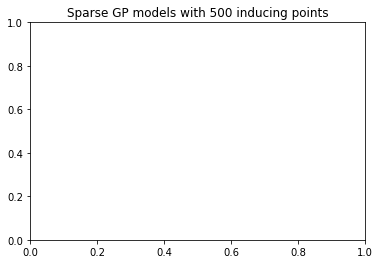

In [11]:
# print(logs)
plt.figure()
plt.title("Sparse GP models with 500 inducing points")
plt.plot(times, elbos, label="SGPR without inducing point training")
plt.plot(times, elbos_Z, label="SGPR with inducing point training")
plt.plot(times_SVGP, elbos_SVGP, label="SVGP without inducing point training (mb size=500)")
#plt.plot(times_SVGP_Z, elbos_SVGP_Z, label="SVGP with inducing point training")
plt.xlabel("Time /s")
plt.ylabel("ELBO")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

plt.figure()
plt.title("Sparse GP models with 500 inducing points")
plt.plot(times, accuracies, label="Without inducing point training")
plt.plot(times, accuracies_Z, label="With inducing point training")
plt.plot(times_SVGP, accuracies_SVGP, label="SVGP without inducing point training (mb size=500)")
#plt.plot(times_SVGP_Z, accuracies_SVGP_Z, label="SVGP with inducing point training")
plt.xlabel("Time /s")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True, "both", alpha=0.2)
plt.show()

In [150]:
col_names =  [
    "Model",
    "M",
    "Train Z",
    "Adam learning rate",
    "minibatch size",
    "iterations",
    "time logs",
    "ELBo logs",
    "accuracy logs",
    "final hyperparams"
    ]
  
# create an empty dataframe
# with columns
my_df  = pd.DataFrame(columns = col_names)
  
# show the dataframe
my_df

,Model,M,Train Z,Adam learning rate,minibatch size,iterations,time logs,ELBo logs,accuracy logs,final hyperparams


In [28]:
my_df.loc[len(my_df.index)] = ("SGPR", 500, True, 0.1, None, 200, times_Z, elbos_Z, accuracies_Z, {"kernel variance": m_SGPR_Z.kernel.variance.numpy(), "kernel lengthscale": m_SGPR_Z.kernel.lengthscales.numpy(), "likelihood variance": m_SGPR_Z.likelihood.variance.numpy()})

my_df.loc[len(my_df.index)] = ("SGPR", 500, False, 0.1, None, 200, times, elbos, accuracies, {"kernel variance": m_SGPR.kernel.variance.numpy(), "kernel lengthscale": m_SGPR.kernel.lengthscales.numpy(), "likelihood variance": m_SGPR.likelihood.variance.numpy()})

my_df.loc[len(my_df.index)] = ("SVGP", 500, False, 0.1, 500, 10000, times_SVGP, elbos_SVGP, accuracies_SVGP, {"kernel variance": m_SVGP.kernel.variance.numpy(), "kernel lengthscale": m_SVGP.kernel.lengthscales.numpy(), "likelihood variance": m_SVGP.likelihood.invlink.epsilon.numpy()})


my_df

NameError: name 'times_Z' is not defined

In [8]:
x_train, x_test, y_train, y_test = load_dataset("mnist", y_hot_encoding=False)

data=(x_train, y_train)

N = len(y_train)

minibatch_size=500

#* Number of inducing points
M = 500
Z = x_train[:M, :].copy()

#* Number of classes for a classification dataset
C = len(unique_labels(y_train))

likelihood = gpflow.likelihoods.Gaussian()

#* Kernel
kernel = gpflow.kernels.SquaredExponential()

#* Initialise the model
m = gpflow.models.SVGP(
        inducing_variable=Z,
        kernel=kernel,
        num_latent_gps=C,
        likelihood=likelihood,
        )

#* Pick value for jitter
jitter = 1e-3
gpflow.config.set_default_jitter(jitter)

#* Initialise hyperparams
# m.likelihood.variance.assign(noi_SVGP)
# # if likelihood=="RobustMax":
# #     m.likelihood.invlink.epsilon.assign(initial_likelihood_hyperparameter)
# m.kernel.variance.assign(var_SVGP)
# m.kernel.lengthscales.assign(len_SVGP)

#* Set trainable parameters
gpflow.set_trainable(m.inducing_variable, False)
gpflow.set_trainable(m.kernel, False)
gpflow.set_trainable(m.likelihood, False)

#* Optimiser object
opt = tf.optimizers.Adam(0.1)

#* List for ELBO values during 
elbo_logs = []
accuracy_logs = []
times = []

#* Stopwatch instance
watch = Stopwatch()
watch.reset()

#* Number of logs to make during optimisation
n_logs = 200

def log_opt():
    """
    Utility function to log the elbo score for each iteration during optimisaiton.

    Args:
        x
    """
    watch.stop()
    ELBO =  m.elbo(data)
    elbo_logs.append(float(ELBO))
    times.append(watch.read_time())
    y_pred, var = m.predict_y(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1).reshape(-1, 1)
    accuracy_logs.append(accuracy_score(y_test, y_pred_labels))
    watch.start()
    
    #// logs.append(float(m.log_marginal_likelihood()))

train_dataset = tf.data.Dataset.from_tensor_slices((data)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(minibatch_size))
training_loss = m.training_loss_closure(train_iter, compile=True)

def run_adam(iterations):
    for i in range(iterations):
        print(train_dataset)
        opt.minimize(
            training_loss,
            m.trainable_variables,
            )
        freq = iterations//n_logs 
        if i % freq == 0:  #-- only log every freq iterations
            log_opt()

watch.start()  # --Start the watch


#* Optimise
run_adam(5000)


watch.stop() # --Stop the watch for the final time
print("Model: {}".format("SVGP"))
print("Number of inducing points: {}".format(500))
print("Total time for optimisation: {} seconds".format(watch.read_time()))
gpflow.utilities.print_summary(m, fmt="notebook")


final_hyperparams = {
    "kernel variance": m.kernel.variance.numpy(),
    "kernel lengthscale": m.kernel.lengthscales.numpy(),
    "likelihood variance": m.likelihood.variance.numpy(),
    "inducing locations": m.inducing_variable.Z.numpy(),
}

2022-05-04 17:01:03.401936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 17:01:03.520203: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


<ShuffleDataset shapes: ((784,), (1,)), types: (tf.float64, tf.uint8)>


ValueError: in user code:

    /Users/jacob/Programming/GPflow/gpflow/models/training_mixins.py:99 training_loss  *
        return self._training_loss(data)
    /Users/jacob/Programming/GPflow/gpflow/models/model.py:56 _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    /Users/jacob/Programming/GPflow/gpflow/models/svgp.py:139 maximum_log_likelihood_objective  *
        return self.elbo(data)
    /Users/jacob/Programming/GPflow/gpflow/models/svgp.py:149 elbo  *
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
    /Users/jacob/Programming/GPflow/gpflow/likelihoods/base.py:288 variational_expectations  *
        self._check_last_dims_valid(Fmu, Y)
    /Users/jacob/Programming/GPflow/gpflow/likelihoods/base.py:448 _check_last_dims_valid  *
        tf.debugging.assert_shapes([(F, (..., "num_latent")), (Y, (..., "num_latent"))])
    /Users/jacob/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /Users/jacob/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/check_ops.py:1762 assert_shapes_v2
        assert_shapes(
    /Users/jacob/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/jacob/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/check_ops.py:1986 assert_shapes
        raise ValueError(

    ValueError: .  Specified by tensor add_8:0 dimension -1.  Tensor data_1:0 dimension -1 must have size 10.  Received size 1, shape (None, 1)
